# Importing packages and modules we need & preprocessing the images

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

data_dir = "/Pictures"

2026-01-27 00:42:08.528804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769474528.751262      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769474528.824559      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769474529.360885      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769474529.360917      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769474529.360920      24 computation_placer.cc:177] computation placer alr

In [2]:
batch_size = 32
img_width = 224
img_height = 224
nb_channels = 3

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 1967 files belonging to 6 classes.
Using 1574 files for training.


I0000 00:00:1769474546.313950      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769474546.317780      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1967 files belonging to 6 classes.
Using 393 files for validation.


In [5]:
len(val_ds)

13

In [6]:
test_ds = val_ds.skip(10)
val_ds = val_ds.take(10)

In [7]:
class_names = train_ds.class_names

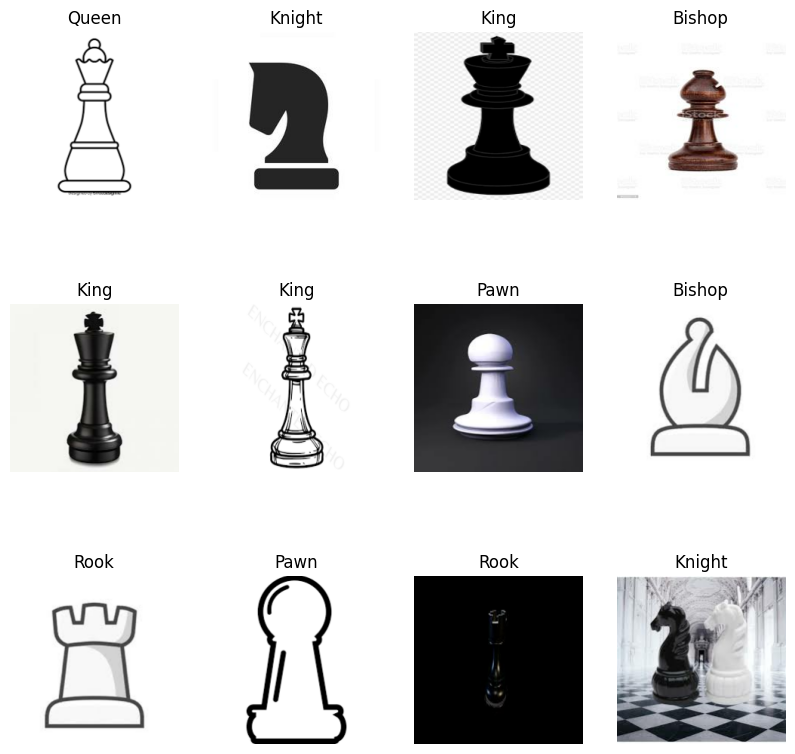

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(height=img_height, width=img_width),
    layers.Rescaling(scale=1./255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1) 
])

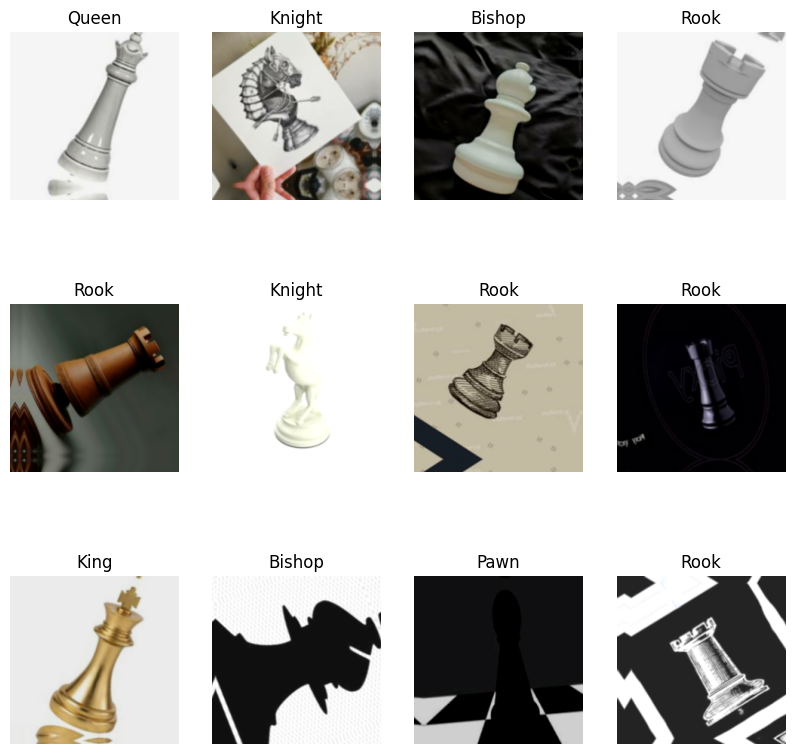

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.map(lambda x, y: (data_augmentation(x), y)).take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Defining a model from scratch

In [13]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(6, activation="softmax")
])

In [14]:
model.build(input_shape=(batch_size, img_width, img_height, nb_channels))

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 86528)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 256)              │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 6)                │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,214 (84.86 MB)

 Trainable params: 22,246,214 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
)

In [17]:
best_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = './best_chess_model.keras',
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only=True
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10
)

In [18]:
history = model.fit(
    train_ds,
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[best_model_callback, early_stop_callback]
)

Epoch 1/100


I0000 00:00:1769474556.486591      74 cuda_dnn.cc:529] Loaded cuDNN version 91002


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.1901 - loss: 16.6464 - val_accuracy: 0.2125 - val_loss: 1.7932
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.2171 - loss: 1.7914 - val_accuracy: 0.2281 - val_loss: 1.7759
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2253 - loss: 1.7805 - val_accuracy: 0.2219 - val_loss: 1.7895
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.2299 - loss: 1.7853 - val_accuracy: 0.2406 - val_loss: 1.7782
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.2313 - loss: 1.7720 - val_accuracy: 0.2469 - val_loss: 1.7756
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2353 - loss: 1.7708 - val_accuracy: 0.2375 - val_loss: 1.7693
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2265 - loss: 1.7724 - val_accuracy: 0.2281 - val_loss: 2.1944
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2300 - loss: 3.3334 - val_accuracy: 0.2313 - val

1.7608169317245483


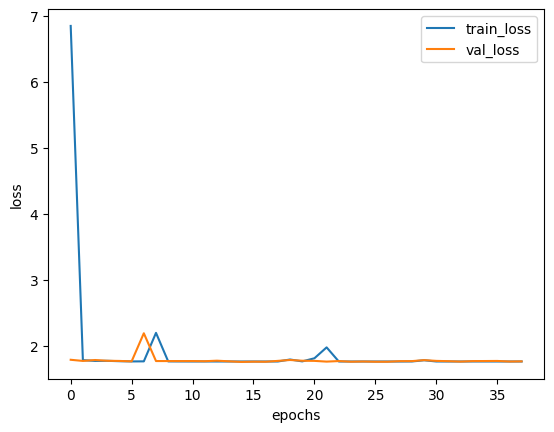

In [19]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
print(min(val_loss))

0.26249998807907104


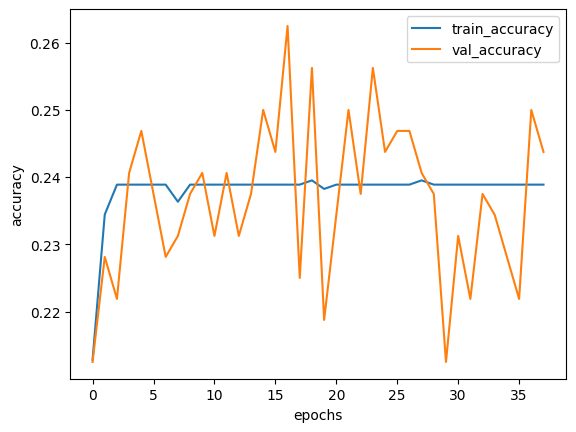

In [20]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
print(max(val_acc))

#### We can clearly see above that it is hard to train a model from scratch, especally with few data we have.
#### The ideal is to fine-tune a pretrained model.

# Fine-tuning pretrained model

## VGG16

In [21]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, nb_channels)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
vgg16.trainable = False

model = tf.keras.Sequential([
    data_augmentation,
    vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Dense(6, activation="softmax")
])

In [24]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [26]:
history = model.fit(
    train_ds,
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[best_model_callback, early_stop_callback]
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.2008 - loss: 5.0675 - val_accuracy: 0.3156 - val_loss: 3.4176
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.3511 - loss: 2.6616 - val_accuracy: 0.4344 - val_loss: 2.4312
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.4917 - loss: 1.8686 - val_accuracy: 0.5031 - val_loss: 2.1206
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.5255 - loss: 1.6366 - val_accuracy: 0.5719 - val_loss: 1.7911
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.5536 - loss: 1.4337 - val_accuracy: 0.5531 - val_loss: 1.6632
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.5814 - loss: 1.4110 - val_accuracy: 0.6094 - val_loss: 1.5423
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.6351 - loss: 1.1825 - val_accuracy: 0.6250 - val_loss: 1.4735
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.6323 - loss: 1.1479 - val_acc

0.5245435833930969


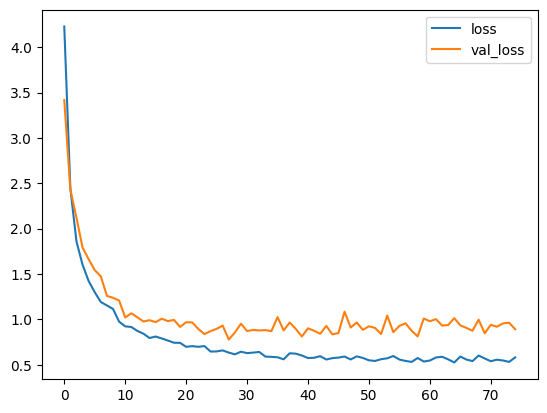

In [27]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
print(min(loss))

0.800000011920929


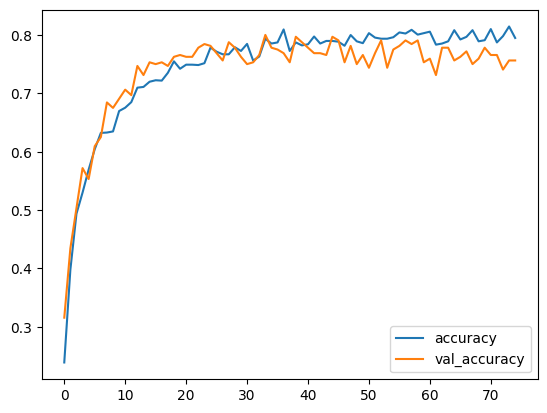

In [28]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(acc, label="accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend()
print(max(val_acc))

#### We can see clearly we are getting better results with VGG16 than the model from scratch !

In [29]:
# Testing the model
model.evaluate(test_ds)

# Loading the best model and testing it
best_model = tf.keras.models.load_model("best_chess_model.keras")
best_model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step - accuracy: 0.7243 - loss: 0.9709
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8221 - loss: 0.7229


[0.7603439688682556, 0.8082191944122314]

#### 78.49% accuracy for the model and 80% for the best we saved during the training

## From here, we will defreeze some layers from the vgg16 and try to train it again with few epochs

In [30]:
len(vgg16.layers)

19

In [31]:
vgg16.trainable = True

In [32]:
for layer in vgg16.layers[:16]:
  layer.trainable = False

In [33]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # we make sure to put a very small learning_rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [35]:
model.fit(
    train_ds,
    epochs=10, # we can try 5 or 10
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.8111 - loss: 0.4989 - val_accuracy: 0.8031 - val_loss: 0.9563
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.8384 - loss: 0.4410 - val_accuracy: 0.8031 - val_loss: 0.9485
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.8450 - loss: 0.4055 - val_accuracy: 0.8094 - val_loss: 0.8250
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.8545 - loss: 0.3907 - val_accuracy: 0.8469 - val_loss: 0.6426
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.8833 - loss: 0.3355 - val_accuracy: 0.8375 - val_loss: 0.8251
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.8829 - loss: 0.3373 - val_accuracy: 0.8438 - val_loss: 0.7402
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.9043 - loss: 0.2730 - val_accuracy: 0.8313 - val_loss: 0.8401
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.8818 - loss: 0.3253 - val_accuracy:

In [36]:
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8651 - loss: 0.7582


[0.7780911922454834, 0.8630136847496033]

#### We have better accuracy than before ;)

In [37]:
# We save our model
# I think there is an issue of saving in Kaggle
model.save("chess_pieces_recognizer_model.keras")